# Data Curation for MNIST Dataset - Assignment 1 (a)

In [1]:
import os
import random
import fiftyone as fo
import fiftyone.zoo as fozoo
import fiftyone.brain as fobrain
from fiftyone import ViewField as F
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torchvision.transforms.v2 as transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd


/home/vincent/.cache/pypoetry/virtualenvs/acv-_NshFyup-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seeds(seed=51):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
BATCH_SIZE = 32
LEARNING_RATE = 0.003
EPOCHS = 10
RELOAD_DATASETS = True
VALIDATION_SPLIT_SIZE = 15 #%
set_seeds(SEED)

In [4]:
class ModernLeNet5(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()

        self.leNet5 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(84, num_classes)
        )

    def slice_embedding_model(self, remove_n=3):
      return nn.Sequential(*list(self.leNet5.children())[:-remove_n])

    def forward(self, x):
        return self.leNet5(x)


In [5]:
if RELOAD_DATASETS:
  for ds in fo.list_datasets():
    print(f"Deleting dataset: {ds}")
    fo.delete_dataset(ds)

Deleting dataset: mnist-train-val


In [6]:
if not "mnist-train-val" in fo.list_datasets():
  train_val_dataset = fozoo.load_zoo_dataset("mnist", split='train', dataset_name="mnist-train-val", persistent=True)
  train_val_dataset.compute_metadata()
  train_val_dataset.untag_samples(["train", "validation"])
else:
  train_val_dataset = fo.load_dataset("mnist-train-val")

if not "mnist-train" in fo.list_datasets() or not "mnist-val" in fo.list_datasets():
  for sample in tqdm(train_val_dataset, desc="Generate Splits"):
    sample.tags = ["train"] if random.random() > VALIDATION_SPLIT_SIZE / 100 else ["validation"]
    sample.save()
  train_dataset = train_val_dataset.match_tags("train").clone()
  train_dataset.name = "mnist-train"
  train_dataset.persistent = True
  val_dataset = train_val_dataset.match_tags("validation").clone()
  val_dataset.name = "mnist-val"
  val_dataset.persistent = True
else:
  train_dataset = fo.load_dataset("mnist-train")
  val_dataset = fo.load_dataset("mnist-val")

if not "mnist-test" in fo.list_datasets():
  test_dataset = fozoo.load_zoo_dataset("mnist", split='test', dataset_name="mnist-test", persistent=True)
else:
  test_dataset = fo.load_dataset("mnist-test")

Split 'train' already downloaded
Loading 'mnist' split 'train'
 100% |█████████████| 60000/60000 [23.1s elapsed, 0s remaining, 2.6K samples/s]      
Dataset 'mnist-train-val' created
Computing metadata...
 100% |█████████████| 60000/60000 [13.2s elapsed, 0s remaining, 4.2K samples/s]      


Generate Splits: 100%|██████████| 60000/60000 [00:43<00:00, 1393.28it/s]


Split 'test' already downloaded
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [4.7s elapsed, 0s remaining, 2.4K samples/s]      
Dataset 'mnist-test' created


In [7]:
print(fo.list_datasets())
session = fo.launch_app(train_dataset, auto=False)
print(session.url)

['mnist-test', 'mnist-train', 'mnist-train-val', 'mnist-val']
Session launched. Run `session.show()` to open the App in a cell output.
http://localhost:5151/


In [8]:
class MNISTDataset(Dataset):
  def __init__(self, fiftyone_dataset, image_transforms=None, label_map=None):
    self.image_paths = fiftyone_dataset.values("filepath")
    self.str_labels = fiftyone_dataset.values("ground_truth.label")
    self.image_transforms = image_transforms or transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
    self.dataset_classes = sorted(fiftyone_dataset.distinct("ground_truth.label"))
    self.label_map = label_map or {str_label: index for index, str_label in enumerate(self.dataset_classes)}

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).convert('L')
    image = self.image_transforms(image) if self.image_transforms else image

    label_str = self.str_labels[idx]
    label_idx = self.label_map[label_str]
    return image, torch.tensor(label_idx, dtype=torch.long)

In [9]:
generator = torch.Generator()
generator.manual_seed(SEED)
train_val_dataset_torch = MNISTDataset(train_val_dataset)
train_val_loader = DataLoader(train_val_dataset_torch, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(MNISTDataset(train_dataset), batch_size=BATCH_SIZE, shuffle=True, generator=generator)
val_loader = DataLoader(MNISTDataset(val_dataset), batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def train(model, optimizer, train_loader, criterion, idx=None):
  batch_losses = []
  model.train()
  with tqdm(desc="Train" + (f"(Epoch {idx})" if idx is not None else ""), leave=False, total=len(train_loader)) as pbar:
    for batch in train_loader:
      pbar.update(1)
      optimizer.zero_grad()
      images, labels = batch
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      outputs = model(images)
      loss = criterion(outputs, labels)
      batch_losses.append(loss.item())
      loss.backward()
      optimizer.step()
    pbar.write(f"Epoch {str(idx) + ' ' if idx is not None else ''} done")
    pbar.write(f"Avg. Train Loss: {np.mean(batch_losses)}")
  return np.mean(batch_losses)

def validate(model, val_loader, criterion, idx=None):
  batch_losses = []
  correct, total = 0, 0
  model.eval()
  with torch.no_grad(), tqdm(desc="Validation" + (f"(Epoch {idx})" if idx is not None else ""), leave=False, total=len(val_loader)) as pbar:
    for images, labels in val_loader:
      pbar.update(1)
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      logits = model(images)
      correct += (logits.argmax(dim=1) == labels).sum().item()
      total += len(labels)
      loss_value = criterion(logits, labels)
      batch_losses.append(loss_value.item())
    val_loss = np.mean(batch_losses)
    pbar.write(f"Avg. Validation Loss: {val_loss}")
    pbar.write(f"Validation Accuracy: {correct / total}")
  return val_loss, correct / total

def plot_losses(train_losses, validation_losses, show_fun = None):
  plt.figure(figsize=(10, 5))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.xticks(range(0, EPOCHS), range(1, EPOCHS + 1))
  plt.legend()
  plt.title('Training and Validation Loss')
  best_epoch = np.argmin(validation_losses)
  plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch}')
  plt.legend()
  if show_fun is not None:
    show_fun(plt)
  else:
    plt.show()

Epoch 1  done
Avg. Train Loss: 0.24088735688691207


Avg. Validation Loss: 0.09467917324905038
Validation Accuracy: 0.9730146491904395


Epoch 2  done
Avg. Train Loss: 0.09113259707211097


Avg. Validation Loss: 0.07104871259808776
Validation Accuracy: 0.9796233065315564


Epoch 3  done
Avg. Train Loss: 0.07216347924517706


Avg. Validation Loss: 0.0621072795771064
Validation Accuracy: 0.9820464808899658


Epoch 4  done
Avg. Train Loss: 0.06343989562389364


Avg. Validation Loss: 0.06601386717052408
Validation Accuracy: 0.9818261923119286


Epoch 5  done
Avg. Train Loss: 0.05357459898839775


Avg. Validation Loss: 0.05953865135686107
Validation Accuracy: 0.9845797995373939


Epoch 6  done
Avg. Train Loss: 0.05391081342529406


Avg. Validation Loss: 0.06423650008740747
Validation Accuracy: 0.9845797995373939


Epoch 7  done
Avg. Train Loss: 0.050471231723847154


Avg. Validation Loss: 0.0792483557393549
Validation Accuracy: 0.9821566251789845


Epoch 8  done
Avg. Train Loss: 0.042372415194285896


Avg. Validation Loss: 0.0657910205779784
Validation Accuracy: 0.9852406652715057


Epoch 9  done
Avg. Train Loss: 0.04452122624075154


Avg. Validation Loss: 0.07763573479106221
Validation Accuracy: 0.9824870580460403


Epoch 10  done
Avg. Train Loss: 0.040692217208503335


Avg. Validation Loss: 0.071261978492181
Validation Accuracy: 0.9843595109593568


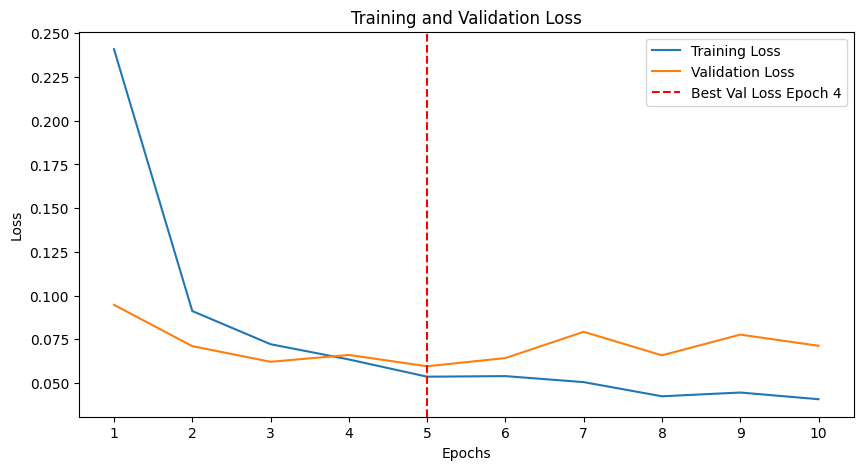

In [ ]:
model = ModernLeNet5().to(DEVICE)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

best_loss = None
save_path = "../out/assignment01a"
os.makedirs(save_path, exist_ok=True)

train_losses, validation_losses = [], []

for epoch in range(EPOCHS):
  train_loss = train(model, optimizer, train_loader, criterion, epoch+1)
  val_loss, val_acc = validate(model, val_loader, criterion, epoch+1)
  train_losses.append(train_loss)
  validation_losses.append(val_loss)

  if best_loss is None or val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), os.path.join(save_path, "model.pt"))

plot_losses(train_losses, validation_losses)


In [ ]:
model = ModernLeNet5()
model.load_state_dict(torch.load(os.path.join(save_path, "model.pt")))
embedding_model = model.slice_embedding_model(3).to(DEVICE)
model.eval()
embedding_model.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=120, out_features=84, bias=True)
)

In [13]:
predictions = None
confidences = None
logits = None
for batch in tqdm(train_val_loader, desc="Generate Predictions joint Train-Val Set"):
    images, labels = batch
    images = images.to(DEVICE)
    outputs = model(images)
    logits_softmax = fn.softmax(outputs, dim=1)
    preds = outputs.argmax(dim=1)
    
    if predictions is None:
        predictions = preds.detach().cpu().numpy()
    else:
        predictions = np.concatenate((predictions, preds.detach().cpu().numpy()), axis=0)

    if confidences is None:
        confidences = logits_softmax[torch.arange(len(preds)), preds].detach().cpu().numpy()
    else:
        confidences = np.concatenate((confidences, logits_softmax[torch.arange(len(preds)), preds].detach().cpu().numpy()), axis=0)

    if logits is None:
        logits = outputs.detach().cpu().numpy()
    else:
        logits = np.concatenate((logits, outputs.detach().cpu().numpy()), axis=0)

print(predictions.shape)
print(confidences.shape)
print(logits.shape)

Generate Predictions joint Train-Val Set: 100%|██████████| 1875/1875 [00:19<00:00, 97.79it/s] 

(60000,)
(60000,)
(60000, 10)


In [14]:
train_embeddings = None

for batch in tqdm(train_val_loader, desc="Generate Train Embeddings"):
  images, labels = batch
  images = images.to(DEVICE)
  embeddings = embedding_model(images)
  if train_embeddings is None:
    train_embeddings = embeddings.detach().cpu().numpy()
  else:
    train_embeddings = np.concatenate((train_embeddings, embeddings.detach().cpu().numpy()), axis=0)
print(train_embeddings.shape)


Generate Train Embeddings: 100%|██████████| 1875/1875 [00:20<00:00, 90.58it/s] 

(60000, 84)


In [15]:
for sample, embedding, prediction, confidence, logits in tqdm(zip(train_val_dataset, train_embeddings, predictions, confidences, logits), total=train_val_dataset.count()):
  sample["embedding"] = embedding
  sample["lenet"] = fo.Classification(
    label=train_val_dataset_torch.dataset_classes[prediction],
    confidence=confidence,
    logits=logits
  )
  sample.save()
train_val_dataset.save()
session.refresh()

100%|██████████| 60000/60000 [01:16<00:00, 783.69it/s]


In [16]:
wrong_view = train_val_dataset.match(F("ground_truth.label") != F("lenet.label"))
session.view = wrong_view
session.refresh()

In [17]:
pca_visualization = fobrain.compute_visualization(train_val_dataset, method="pca", embeddings="embedding", num_dims=2, brain_key="pca_visualization_lenet_embeds")
pca_visualization = fobrain.compute_visualization(train_val_dataset, method="umap", embeddings="embedding", num_dims=2, brain_key="umap_visualization_lenet_embeds")
session.view = train_val_dataset.view()
session.refresh()

Generating visualization...
Generating visualization...
UMAP( verbose=True)
Wed Oct 22 20:43:54 2025 Construct fuzzy simplicial set
Wed Oct 22 20:43:54 2025 Finding Nearest Neighbors
Wed Oct 22 20:43:54 2025 Building RP forest with 17 trees
Wed Oct 22 20:44:01 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Wed Oct 22 20:44:12 2025 Finished Nearest Neighbor Search
Wed Oct 22 20:44:14 2025 Construct embedding


Epochs completed:   2%| ▏          3/200 [00:02]

	completed  0  /  200 epochs


Epochs completed:  12%| █▏         23/200 [00:04]

	completed  20  /  200 epochs


Epochs completed:  22%| ██▏        43/200 [00:05]

	completed  40  /  200 epochs


Epochs completed:  32%| ███▏       63/200 [00:07]

	completed  60  /  200 epochs


Epochs completed:  42%| ████▏      83/200 [00:08]

	completed  80  /  200 epochs


Epochs completed:  52%| █████▏     103/200 [00:09]

	completed  100  /  200 epochs


Epochs completed:  62%| ██████▏    123/200 [00:11]

	completed  120  /  200 epochs


Epochs completed:  72%| ███████▏   143/200 [00:12]

	completed  140  /  200 epochs


Epochs completed:  82%| ████████▏  163/200 [00:14]

	completed  160  /  200 epochs


Epochs completed:  92%| █████████▏ 183/200 [00:15]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:17]


Wed Oct 22 20:44:45 2025 Finished embedding


In [18]:
fobrain.compute_mistakenness(train_val_dataset, pred_field="lenet", label_field="ground_truth")
fobrain.compute_hardness(train_val_dataset, label_field="lenet")
session.view = train_val_dataset.view()
session.refresh()

Computing mistakenness...


 100% |█████████████| 60000/60000 [1.4m elapsed, 0s remaining, 694.0 samples/s]      
Mistakenness computation complete
Computing hardness...
 100% |█████████████| 60000/60000 [1.5m elapsed, 0s remaining, 700.3 samples/s]      
Hardness computation complete


In [19]:
highly_mistaken_quantile = train_val_dataset.quantiles("mistakenness", [0.99])[0]
highly_mistaken = train_val_dataset.match(F("mistakenness") > highly_mistaken_quantile)
highly_hard_quantile = train_val_dataset.quantiles("hardness", [0.99])[0]
highly_hard = train_val_dataset.match(F("hardness") > highly_hard_quantile)
missclassed_samples = train_val_dataset.match(F("ground_truth.label") != F("lenet.label"))

mistaken_or_hard = highly_mistaken.select(set(highly_mistaken.values("id")).union(set(highly_hard.values("id"))))
histaken_or_hard_and_missclassed = mistaken_or_hard.select(set(mistaken_or_hard.values("id")).intersection(set(missclassed_samples.values("id")))) 
problematic_samples = histaken_or_hard_and_missclassed.sort_by("hardness", reverse=True)
problematic_ids = problematic_samples.values("id")
for sample in tqdm(train_val_dataset, desc="Tagging Problematic Samples"):
    sample["ground_truth.label"] = "problematic " + sample["ground_truth.label"] if sample.id in problematic_ids else sample["ground_truth.label"]
    sample.save()
train_val_dataset.save()
session.view = problematic_samples.view()
session.refresh()

Tagging Problematic Samples: 100%|██████████| 60000/60000 [00:57<00:00, 1046.46it/s]


In [20]:
export_dir = "../data/mnist-curated"

train_val_dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field="ground_truth"
)

Directory '../data/mnist-curated' already exists; export will be merged with existing files
 100% |█████████████| 60000/60000 [53.9s elapsed, 0s remaining, 1.1K samples/s]      


In [21]:
export_dir = Path("../data/mnist-curated")
overview_data = [{"file": str(p).lstrip("../data/mnist-curated/"), "label": str(p.parent.name)} for p in export_dir.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg"}]
overview_df = pd.DataFrame(overview_data)
overview_df.to_csv(export_dir / "overview.csv", index=False)